<a href="https://colab.research.google.com/github/AnIsAsPe/Fundamentos-tecnicos-y-aplicaciones-ML/blob/main/Clasificador_Naive_Bayes%2C_art%C3%ADculos_TDS_TheStartup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Leer csv con los articulos guardados de todo 2020

In [17]:
import numpy as np
import pandas as pd

#preprocesar texto
import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB  


nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt        #Para graficar y visualizar
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
#leemos el conjunto de datos de los articulos de Towards Data Science
df_tds = pd.read_csv('/content/drive/MyDrive/Datos/Scraping/TowardsDataScience_articulos_muestra_2020.csv',
                 usecols=['titulo', 'subtitulo',])

#¿cuántos renglones y cuántas columnas tienen el conjunto de datos?
print(df_tds.shape) 

df_tds.head(3)

(1334, 2)


,titulo,subtitulo
0,10 Smooth Python Tricks For Python Gods,10 Tricks that will individualize and better y...
1,How to process a DataFrame with billions of ro...,Yet another Python library for Data…
2,SPY vs. VOO: Is there any difference?,Analysis and comparison of two popular S&P 500...


In [19]:
#leemos el conjunto de datos de los articulos de The Startup
df_startup = pd.read_csv('/content/drive/MyDrive/Datos/Scraping/TheStartup_articulos_muestra_2020.csv',
                 usecols=[ 'titulo', 'subtitulo'])

#¿cuántos renglones y cuántas columnas tienen el conjunto de datos?
print(df_startup.shape) 

df_startup.head(3)

(1537, 2)


,titulo,subtitulo
0,AWS API Gateway private integration with HTTP ...,Tutorial
1,Experimenting with generics in Go,-
2,Understanding Java Streams,-


In [20]:
datos = pd.concat([df_tds, df_startup], keys=['tds','startup'])
datos = datos.reset_index(level=0)
datos.columns = ['publicacion','titulo','subtitulo']
datos= datos.reset_index(drop=True)
print(datos.shape)
datos.head()

(2871, 3)


,publicacion,titulo,subtitulo
0,tds,10 Smooth Python Tricks For Python Gods,10 Tricks that will individualize and better y...
1,tds,How to process a DataFrame with billions of ro...,Yet another Python library for Data…
2,tds,SPY vs. VOO: Is there any difference?,Analysis and comparison of two popular S&P 500...
3,tds,You Want to Learn Rust but You Don’t Know Wher...,A Complete Resource for Rust Beginners
4,tds,Customer Segmentation in Python,UNSUPERVISED LEARNING


In [21]:
datos.tail()

,publicacion,titulo,subtitulo
2866,startup,Experimental Studies,-
2867,startup,Ensemble Learning- An Integral Aspect of Machi...,-
2868,startup,Overview of the TIFIA Program,Analyzing a program without easily downloadabl...
2869,startup,Sequelize Database Migrations and Models With ...,-
2870,startup,Steps to achieve the Perfect Way to move forwa...,-


In [22]:
datos.sample(30)

,publicacion,titulo,subtitulo
1729,startup,Roulette: The House Always Wins (Python Simula...,-
792,tds,How powerful can an ensemble of linear models be?,How an ensemble of linear models got in the to...
2740,startup,An Exceptional Company Should Also Have Except...,"Unfortunately, that isn’t always the case…"
23,tds,Statistical pitfalls in data science,How stereotypical results can alter data distr...
613,tds,K-means Clustering on Ordinal Data,Using a mapping to uncover the numeric-like be...
21,tds,"Git-Flow is the Source of Productivity, Not Co...",Nuts and bolts of the two most essential…
103,tds,A Complete Guide to Using TensorBoard with PyT...,-
1544,startup,Surprised That Big Tech Failed Us? Here Is How...,While the recent headlines about…
109,tds,Monte Carlo Tree Search: Implementing Reinforc...,-
2095,startup,Two Writing Styles That Every Business Author ...,-


## Preprocesamiento

###Juntar todo titulos y subtitulos en nueva variable "descripción

In [23]:
datos['descripcion'] = datos['titulo'].str.cat(datos['subtitulo'], sep = ". ")
datos = datos.drop(['titulo','subtitulo'], axis=1)
datos.head(3)

,publicacion,descripcion
0,tds,10 Smooth Python Tricks For Python Gods. 10 Tr...
1,tds,How to process a DataFrame with billions of ro...
2,tds,SPY vs. VOO: Is there any difference?. Analysi...


## Preprocesamiento de texto

In [24]:
def preprocesar(texto):
  #convierte a minúsculas
  texto = texto.lower()

  #elimina stopwords
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  texto = stop.sub('', texto) 

  #stemmer 
  tokens =  nltk.word_tokenize(texto)
  stemmer = SnowballStemmer("english")

  stems = [stemmer.stem(token) for token in tokens]
  texto=' '.join(stems) 

  #quita direcciones html
  borrar = re.compile('<.*?>')
  texto= re.sub(borrar, '', texto)

  #quita puntuaciones y todo lo que no sea letra y números
  texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)

  #quita numeros
  texto = re.sub(" \d+", " ", texto)
  
  return(texto)

In [25]:
datos['descripcion'].str.len().describe()

count    2871.000000
mean       82.010101
std        24.651132
min         4.000000
25%        63.000000
50%        92.000000
75%       101.000000
max       204.000000
Name: descripcion, dtype: float64

In [11]:
# Explorar título más largo
idx = datos['descripcion'].index[datos['descripcion'].str.len() == 204][0]
desc_max = datos.loc[idx,'descripcion']
desc_max

'Regression-based decision trees: Predicting Average Daily Rates for\xa0Hotels. The purpose of a decision tree is to visualise features of a model by means of a tree-like graph, and infer the importance (and…'

In [26]:
preprocesar(desc_max)

'regression bas decis tree predict averag daili rate hotel purpos decis tree visualis featur model mean tree lik graph infer import '

Lo hacemos para todos los titulos, utilizando el método  ```.apply()```

In [27]:
datos['descripcion_pp'] = datos['descripcion'].apply(preprocesar)

In [28]:
datos.sample(10)

,publicacion,descripcion,descripcion_pp
779,tds,How to Formulate Good Research Question for Da...,formul good research question data analysi lea...
1951,startup,Probability Sampling with R. R for Probability...,probabl sampl r r probabl statist
2597,startup,Look for the Helpers. Building excellence is a...,look helper build excel simpl look helper work
908,tds,Unfolding AlphaFold. DeepMind AlphaFold Algori...,unfold alphafold deepmind alphafold algorithm ...
1094,tds,7 Statistical Distributions that every Data Sc...,7 statist distribut everi data scientist know ...
945,tds,Reducing Number of Features for Inference. Spr...,reduc number featur infer spread data across f...
946,tds,React & D3: Preparing The Data With D3.Nest. -,react d3 prepar data d3 nest
354,tds,Publish Python Project Documentation on Conflu...,publish python project document confluence htm...
2302,startup,"Forget New Year’s Resolutions, Do These Things...",forget new year resolut thing build better hab...
733,tds,A Machine Predicts My Next Sentence. Using Doc...,machin predict next sentenc use docker tensorf...


###Vectorizar texto (X)

In [29]:
#Vectorizar texto
cv = CountVectorizer()
mdt_frec = cv.fit_transform(datos['descripcion_pp']) 
terminos= cv.get_feature_names()
mdt = pd.DataFrame(mdt_frec.todense(), 
                              index=datos.index, 
                              columns=terminos)
print(mdt.shape)  

mdt.head(3)

(2871, 4729)


,10,11,12,15,16,17,18,20,2020,25,26,30,3d,5g,ab,abandon,abil,abl,abnorm,abroad,abrupt,absolut,abstract,acceler,accelerate,acceleromet,accent,accept,access,accomplish,accord,account,accur,accuraci,achiev,achill,acknowledg,acm,acquisit,across,...,xlm,xlnet,xml,xor,xpath,xss,yahoo,yann,yatzi,ycombin,ye,yea,year,years,yeast,yelp,yes,yet,yield,yml,yoda,yoga,yolo,yolov3,york,young,younger,youngl,youtub,z3r0trust,z3score,zaharia,zealand,zen,zero,zier,zip,zoom,zsh,zuckerberg
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
X = mdt
y = datos['publicacion']

## Separar conjunto de entrenamiento y prueba

In [32]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                     random_state=3, shuffle=True)

print('titulos totales: {}'.format(datos.shape[0]))
print('titulos en el conjunto de entrenamiento: {}'.format(X_train.shape[0]))
print('titulos en el conjunto de prueba: {}'.format(X_test.shape[0]))

titulos totales: 2871
titulos en el conjunto de entrenamiento: 2009
titulos en el conjunto de prueba: 862


In [33]:
#proporción de emails por clase en el conjunto de entrenamiento
y_train.value_counts(normalize=True)

startup    0.532603
tds        0.467397
Name: publicacion, dtype: float64

In [34]:
#proporción de emails por clases en el conjunto de prueba
y_test.value_counts(normalize=True)

startup    0.541763
tds        0.458237
Name: publicacion, dtype: float64

##  Clasificador Naive-Bayes 


####Entrenamiento

In [35]:
#https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes
clasificador = MultinomialNB()
clasificador.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
clasificador.classes_

array(['startup', 'tds'], dtype='<U7')


El atributo ```feature_count_``` devuelve un vector, por cada clase,  con la frecuencia de aparición de cada uno de los términos





In [37]:
print(clasificador.feature_count_.shape)
clasificador.feature_count_

(2, 4729)


array([[3., 0., 0., ..., 2., 0., 1.],
       [5., 0., 1., ..., 0., 0., 0.]])


El atributo ```feature_log_prob_``` devuelve un vector, por cada clase,  con la probabilidad en escala logaritmica de cada término





In [38]:
print(clasificador.feature_log_prob_.shape)
clasificador.feature_log_prob_

(2, 4729)


array([[-8.04694953, -9.43324389, -9.43324389, ..., -8.33463161,
        -9.43324389, -8.74009671],
       [-7.71266742, -9.50442689, -8.81127971, ..., -9.50442689,
        -9.50442689, -9.50442689]])

***fijarse como siempre que aparece un 0 en la frecuencia de cada palabra por clase, obtenemos la misma log probabilidad, en cada clase***

In [39]:
#probabilidad cuando hay frecuencia 0 en la clase  0('no spam')
sum_palabras_startup = np.sum(clasificador.feature_count_, axis=1)[0]

np.log(1/(sum_palabras_startup+ len(terminos)))

-9.433243894485784

In [40]:
#probabilidad cuando hay frecuencia 0 en la clase  1('spam')
sum_palabras_tds = np.sum(clasificador.feature_count_, axis=1)[1]

np.log(1/(sum_palabras_tds + len(terminos)))

-9.504426892100957

In [41]:
#terminos con más peso para clasificar en startup
for p in clasificador.feature_log_prob_.argsort()[0,-10:]:
  print(terminos[p])

product
get
make
build
work
creat
learn
data
write
use


In [42]:
#terminos con más peso para clasificar en tds
for p in clasificador.feature_log_prob_.argsort()[1,-10:]:
  print(terminos[p])

analysi
ai
build
model
scienc
machin
python
use
learn
data


#### Evaluación del modelo

In [44]:
y_pred = clasificador.predict(X_test)

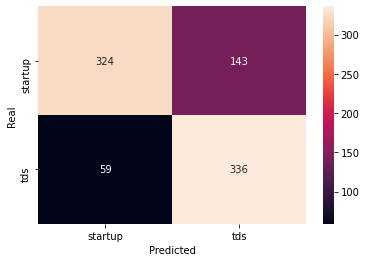

In [45]:
data = {'Y_Real':  y_test,
        'Y_Prediccion':y_pred
        }

df = pd.DataFrame(data, columns=['Y_Real','Y_Prediccion'])
confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

In [48]:
resultados_prediccion = pd.merge(df, datos['descripcion'], how='left', 
                                 left_index=True, right_index= True)
resultados_prediccion.head(3)

,Y_Real,Y_Prediccion,descripcion
2079,startup,tds,Heterogeneous Database Replication to TiDB. Au...
2159,startup,startup,“Why do You Want to be a Product Manager?”. A ...
1844,startup,startup,Habits of Successful People. What is it that s...


In [49]:
#artículos mal clasificados
resultados_prediccion[resultados_prediccion['Y_Real']!=resultados_prediccion['Y_Prediccion']]

,Y_Real,Y_Prediccion,descripcion
2079,startup,tds,Heterogeneous Database Replication to TiDB. Au...
724,tds,startup,Why it’s difficult to sell AI-driven solutions...
2619,startup,tds,Making Space Again. -
250,tds,startup,Introduction to Robotic Control Systems. -
403,tds,startup,How Google Search Might Exist Forever. SOFTWAR...
...,...,...,...
942,tds,startup,Clinical Notes — The “Negative” Story. -
1990,startup,tds,Magic Python: mixing magics. -
2523,startup,tds,Data Personhood. How to solve the wealth trans...
1958,startup,tds,Getting Sentimental. -


In [50]:
resultados_prediccion.loc[2682,'descripcion']

'When Blockchain Meets Artificial Intelligence. The convergence of Blockchain and AI can enhance\xa0machine…'

#Referencias: 

1. Synced. Applying Multinomial Naive Bayes to NLP Problems: A Practical Explanation [Internet]. Medium. 2017 [citado 5 de enero de 2021]. Disponible en: https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf
2. srosassm_textclassification [Internet]. [citado 5 de enero de 2021]. Disponible en: http://cs.wellesley.edu/~srosassm/cs234/digital/srosassm_textclassification.html
